## Project Template

In [1]:
from pyspark.sql import SparkSession
import pyspark.sql.functions as F
from delta import *
from delta.tables import *
import os
import uuid
import time

builder = SparkSession.builder.appName("Streaming2_practice") \
    .config("spark.sql.extensions", "io.delta.sql.DeltaSparkSessionExtension") \
    .config("spark.sql.catalog.spark_catalog", "org.apache.spark.sql.delta.catalog.DeltaCatalog") \
    .config("spark.sql.streaming.statefulOperator.checkCorrectness.enabled", "false") \
    .config("spark.jars.packages", 'org.apache.spark:spark-sql-kafka-0-10_2.12:3.0.0') \
    .config("spark.sql.repl.eagerEval.enabled", True) \
    .config("spark.sql.adaptive.enabled", "false") \
    .config("spark.sql.debug.maxToStringFields", "10000")

spark = configure_spark_with_delta_pip(builder).getOrCreate() # type: ignore


In [2]:
from pyspark.sql.types import StructType, StructField, StringType, TimestampType, FloatType

schema = StructType(
      [
        StructField("hack_license", StringType(), False),
        StructField("pick_up_location", StringType(), False),
        StructField("drop_off_location", StringType(), False),
        StructField("pick_up_time", TimestampType(), False),
        StructField("drop_off_time", TimestampType(), False),
        StructField("timestamp", TimestampType(), False),
      ]
    )

In [33]:
brokers = os.getenv('KAFKA_ADVERTISED_LISTENERS')
protocol = os.getenv('KAFKA_LISTENER_SECURITY_PROTOCOL_MAP') 

lines = (spark.readStream
    .format("kafka")
    .option("kafka.bootstrap.servers", brokers)
    .option("kafka.security.protocol", protocol)
    .option("subscribe", "stock")
    .option("startingOffsets", "earliest")
    .option("maxOffsetsPerTrigger", 100)
    .load()
)

df = lines.select(F.from_json(lines.value.cast("string"), schema).alias("data")).select("data.*")
df.writeStream.format("console").start().awaitTermination(5)


False

## [Query 1] Utilization over a window of 5, 10, and 15 minutes per taxi/driver. This can be computed by computing the idle time per taxi. How does it change? Is there an optimal window?

In [34]:
from datetime import datetime

checkpoint_path = "./checkpoint" 
output_path = "./output"
watermark_duration = "30 minutes"


# Set up queries for each window duration
queries = []
windows = [5, 10, 15]
for duration in windows:
    table = f"idle_time_{duration}"
    window_duration = f"{duration} minutes"

    # Define watermarks on the timestamp field used for windowing
    df_stream_current = df.withWatermark("drop_off_time", "2 hours")
    df_stream_next = df.withWatermark("pick_up_time", "2 hours")

    # Join using conditions that include a time range based on watermarks
    join_condition = [
        F.col("current.hack_license") == F.col("next.hack_license"),
        F.col("current.drop_off_time") < F.col("next.pick_up_time"),
        F.col("next.pick_up_time") <= F.col("current.drop_off_time") + F.expr("interval 24 hours")
    ]

    df_next_trip = df_stream_current.alias("current").join(
        df_stream_next.alias("next"),
        on=join_condition,
        how="left_outer"
    ).select(
        F.col("current.hack_license"),
        F.col("current.drop_off_time"),
        F.col("next.pick_up_time"),
        F.expr("unix_timestamp(next.pick_up_time) - unix_timestamp(current.drop_off_time)").alias("idle_time")
    )

   
    slide_duration = "2 minutes"

    # Calculate total idle time per taxi
    idle_time_per_taxi = df_next_trip.groupBy(
        F.window(F.col("drop_off_time"), window_duration, slide_duration),
        F.col("hack_license")
    ).agg(
        F.sum("idle_time").alias("total_idle_time")
    )

    # Filter out negative idle times (if any)
    idle_time_filtered = idle_time_per_taxi.filter(F.col("total_idle_time") > 0)

    # Write the stream to a Delta table
    query = idle_time_filtered.writeStream \
    .outputMode("append") \
    .format("delta") \
    .trigger(processingTime="120 seconds") \
    .option("checkpointLocation", f"{checkpoint_path}/{table}") \
    .option("path", f"{output_path}/{table}") \
    .option("mergeSchema", "true") \
    .start()

In [ ]:
for query in queries:
    query.stop()

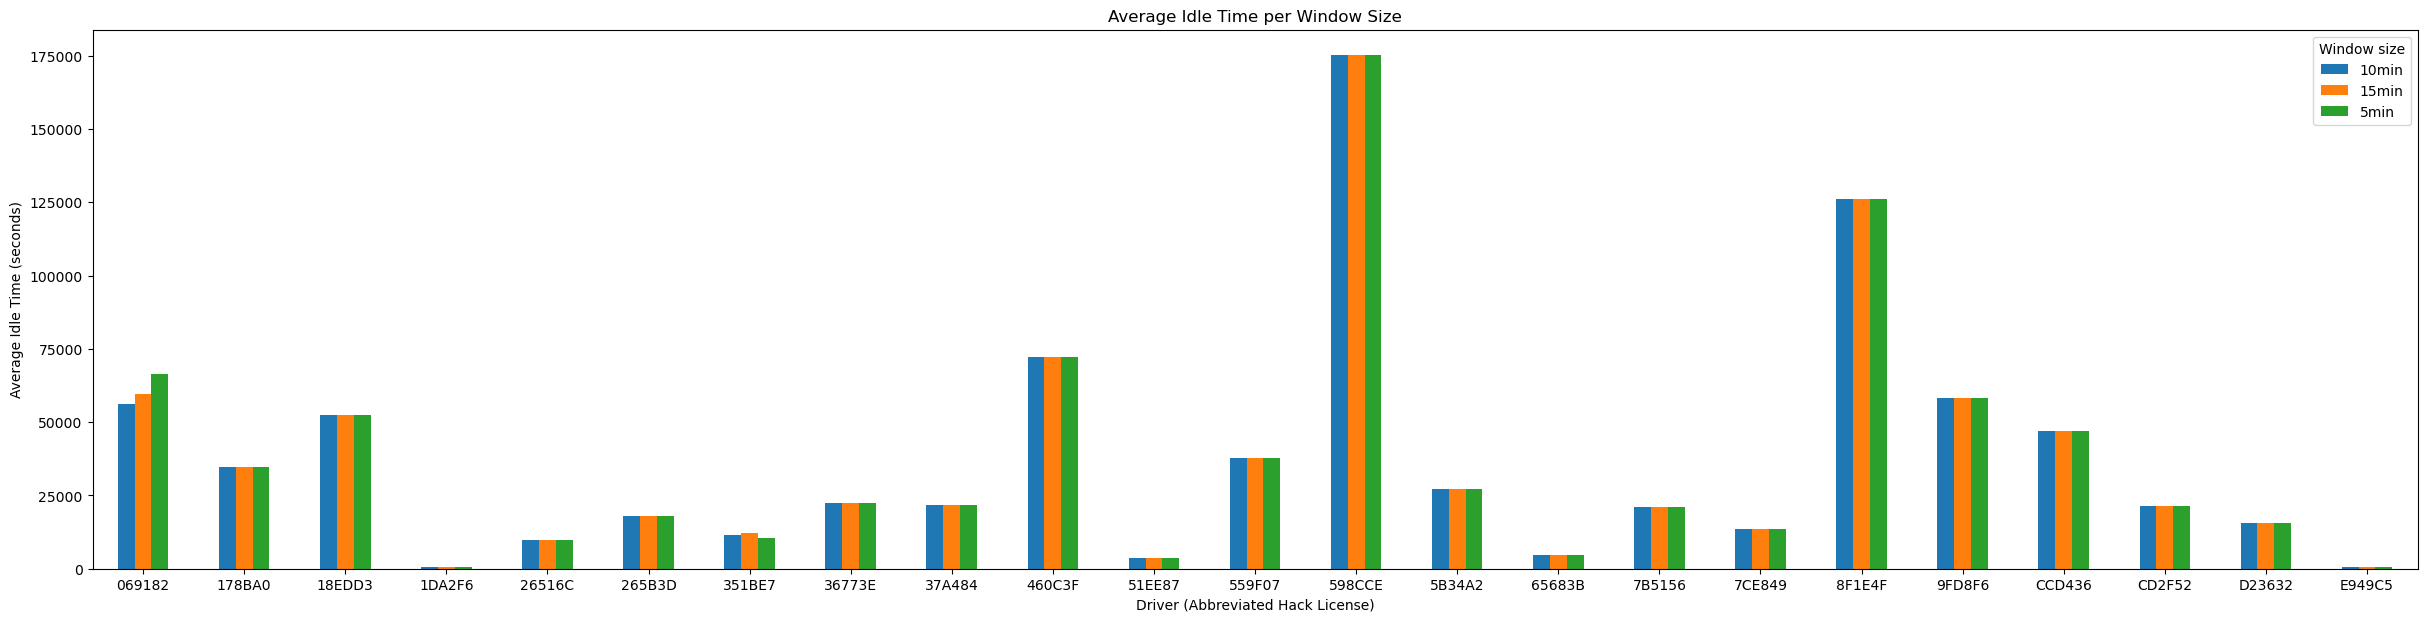

In [35]:
import matplotlib.pyplot as plt
import pandas as pd

# Assuming you have a function to read delta tables into a dataframe
def read_delta_table(path):
    return spark.read.format("delta").load(path).toPandas()

# Collect data from different window outputs
data_frames = {duration: read_delta_table(f"{output_path}/idle_time_{duration}") for duration in windows}

for duration, df in data_frames.items():
    df['window_size'] = f"{duration}min"  # Add window size as a string, e.g., '5min'

# Combine all data frames into one
combined_df = pd.concat(data_frames.values(), ignore_index=True)

# Drop the 'window' column if no longer needed
combined_df.drop('window', axis=1, inplace=True)

# Abbreviate the hack license to the first 6 characters
combined_df['hack_license'] = combined_df['hack_license'].apply(lambda x: x[:6])

# Pivot the DataFrame
pivot_df = combined_df.pivot_table(index='hack_license', columns='window_size', values='total_idle_time', aggfunc='mean')

# Optional: Reset the index if you want 'hack_license' as a regular column for plotting
pivot_df.reset_index(inplace=True)

# Plotting
pivot_df.set_index('hack_license').plot(kind='bar', figsize=(30, 7))
plt.title('Average Idle Time per Window Size')
plt.xlabel('Driver (Abbreviated Hack License)')
plt.ylabel('Average Idle Time (seconds)')
plt.xticks(rotation=0)
plt.legend(title='Window size')
plt.show()

## [Query 2] The average time it takes for a taxi to find its next fare(trip) per destination borough. This can be computed by finding the time difference, e.g. in seconds, between the trip's drop off and the next trip's pick up within a given unit of time

In [4]:
brokers = os.getenv('KAFKA_ADVERTISED_LISTENERS')
protocol = os.getenv('KAFKA_LISTENER_SECURITY_PROTOCOL_MAP') 

lines_2 = (spark.readStream
    .format("kafka")
    .option("kafka.bootstrap.servers", brokers)
    .option("kafka.security.protocol", protocol)
    .option("subscribe", "stock")
    .option("startingOffsets", "earliest")
    .option("maxOffsetsPerTrigger", 100)
    .load()
)
df_2 = lines_2.select(F.from_json(lines_2.value.cast("string"), schema).alias("data")).select("data.*")
df_2.writeStream.format("console").start().awaitTermination(5)


False

In [9]:
checkpoint_path = "./checkpoint" 
output_path = "./output"

# Define watermarks on the timestamp field used for windowing
# Apply watermarks to both DataFrames on the timestamp fields
df_stream_current = df_2.withWatermark("drop_off_time", "2 hours")
df_stream_next = df_2.withWatermark("pick_up_time", "2 hours")

# Join using conditions that include a time range based on watermarks
join_condition = [
    F.col("current.hack_license") == F.col("next.hack_license"),
    F.col("current.drop_off_time") < F.col("next.pick_up_time"),
    F.col("next.pick_up_time") <= F.col("current.drop_off_time") + F.expr("interval 24 hours") #boundary condition
]


df_next_trip = df_stream_current.alias("current").join(
    df_stream_next.alias("next"),
    on=join_condition,
    how="left_outer"
).select(
    F.col("current.drop_off_location").alias("drop_off_borough"),
    F.col("current.drop_off_time"),
    F.col("next.pick_up_time").alias("next_pick_up_time"),
    F.expr("unix_timestamp(next_pick_up_time) - unix_timestamp(current.drop_off_time)").alias("time_to_next_fare")
)

# Define a window for aggregation
window_duration = "1 hour"
slide_duration = "15 minutes"


# Calculate average time to the next fare per borough
avg_time_to_next_fare = df_next_trip.groupBy(
    F.window(F.col("drop_off_time"), window_duration, slide_duration),
    F.col("drop_off_borough")
).agg(
    F.avg("time_to_next_fare").alias("avg_time_to_next_fare")
)
avg_time_to_next_fare.writeStream.format("console").start().awaitTermination(5)

avg_time_to_next_fare_filtered = avg_time_to_next_fare.filter(F.col("avg_time_to_next_fare") > 0).filter(F.expr("drop_off_borough is not null"))


query = avg_time_to_next_fare_filtered.writeStream \
    .outputMode("append") \
    .format("delta") \
    .trigger(processingTime="120 seconds") \
    .option("checkpointLocation", f"{checkpoint_path}/next_fare") \
    .option("path", f"{output_path}/next_fare") \
    .option("mergeSchema", "true") \
    .start()

                                       window drop_off_borough  \
0  (2013-01-07 13:00:00, 2013-01-07 14:00:00)                4   
1  (2013-01-07 13:00:00, 2013-01-07 14:00:00)                1   
2  (2013-01-07 17:15:00, 2013-01-07 18:15:00)                1   
3  (2013-01-07 07:45:00, 2013-01-07 08:45:00)                1   
4  (2013-01-08 12:30:00, 2013-01-08 13:30:00)                1   

   avg_time_to_next_fare  
0                 5509.0  
1                 7157.0  
2                24101.0  
3                 6031.0  
4                 3827.5  


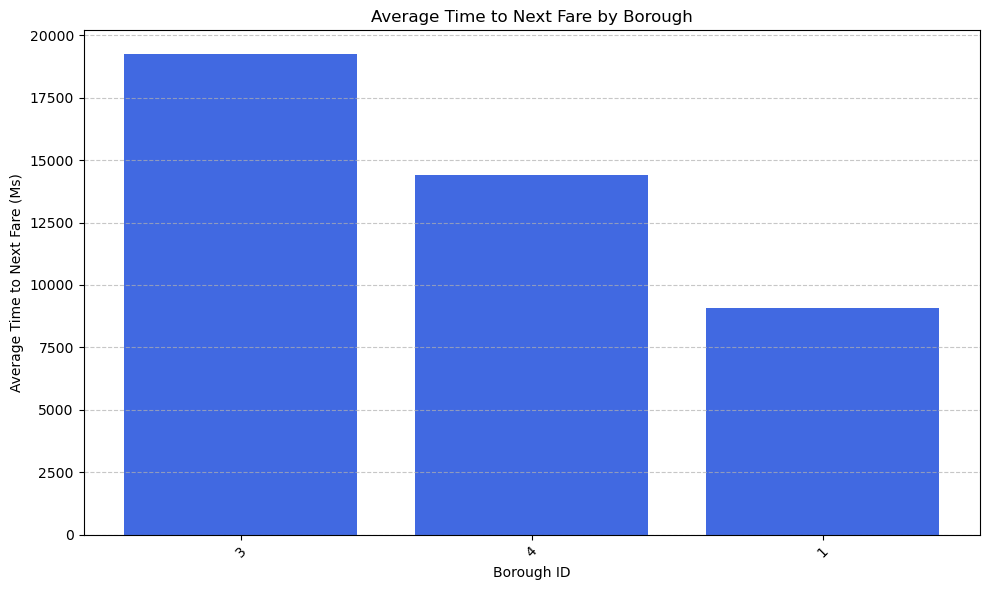

In [12]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np


def read_delta_table(path):
    return spark.read.format("delta").load(path).toPandas()

pd_fares = read_delta_table(f"{output_path}/next_fare")
print(pd_fares.head())

pd_fares['window_start'] = pd_fares['window'].apply(lambda x: pd.to_datetime(x[0]))
pd_fares['window_end'] = pd_fares['window'].apply(lambda x: pd.to_datetime(x[1]))
pd_fares.dropna(subset=['avg_time_to_next_fare'], inplace=True)

# Calculate the overall average time to the next fare per borough
brought_same_number = pd_fares.groupby('drop_off_borough').agg({'avg_time_to_next_fare': 'mean'}).reset_index()
brought_same_number.sort_values(by='avg_time_to_next_fare', ascending=False, inplace=True)

plt.figure(figsize=(10, 6))
plt.bar(brought_same_number['drop_off_borough'].astype(str), brought_same_number['avg_time_to_next_fare'], color='royalblue')

plt.xlabel('Borough ID')
plt.ylabel('Average Time to Next Fare (Ms)')
plt.title('Average Time to Next Fare by Borough')
plt.xticks(rotation=45)  # Rotate the labels for better readability
plt.grid(axis='y', linestyle='--', alpha=0.7)  # Add horizontal grid lines for better alignment

plt.tight_layout()
plt.show()

## [Query 3] The number of trips that started and ended within the same borough in the last hour

In [4]:
brokers = os.getenv('KAFKA_ADVERTISED_LISTENERS')
protocol = os.getenv('KAFKA_LISTENER_SECURITY_PROTOCOL_MAP') 

lines_3 = (spark.readStream
    .format("kafka")
    .option("kafka.bootstrap.servers", brokers)
    .option("kafka.security.protocol", protocol)
    .option("subscribe", "stock")
    .option("startingOffsets", "earliest")
    .option("maxOffsetsPerTrigger", 100)
    .load()
)
df_3 = lines_3.select(F.from_json(lines_3.value.cast("string"), schema).alias("data")).select("data.*")
df_3.writeStream.format("console").start().awaitTermination(5)

False

In [6]:
checkpoint_path = "./checkpoint" 
output_path = "./output"
table = "same_borough"
df_stream = df_3.withWatermark("drop_off_time", "1 hour")
same_borough_trips = df_stream.filter(
    F.col("pick_up_location") == F.col("drop_off_location")
)
window_duration = "1 hour"
slide_duration = "15 minutes"

# Group by the sliding window and borough, then count the entries
trips_per_borough_per_hour = same_borough_trips.groupBy(
    F.window(F.col("drop_off_time"), window_duration, slide_duration),
    F.col("drop_off_location")
).count().withColumnRenamed("count", "number_of_trips")


query = trips_per_borough_per_hour.writeStream \
    .outputMode("append") \
    .format("delta") \
    .trigger(processingTime="120 seconds") \
    .option("checkpointLocation", f"{checkpoint_path}/{table}") \
    .option("path", f"{output_path}/{table}") \
    .option("mergeSchema", "true") \
    .start()

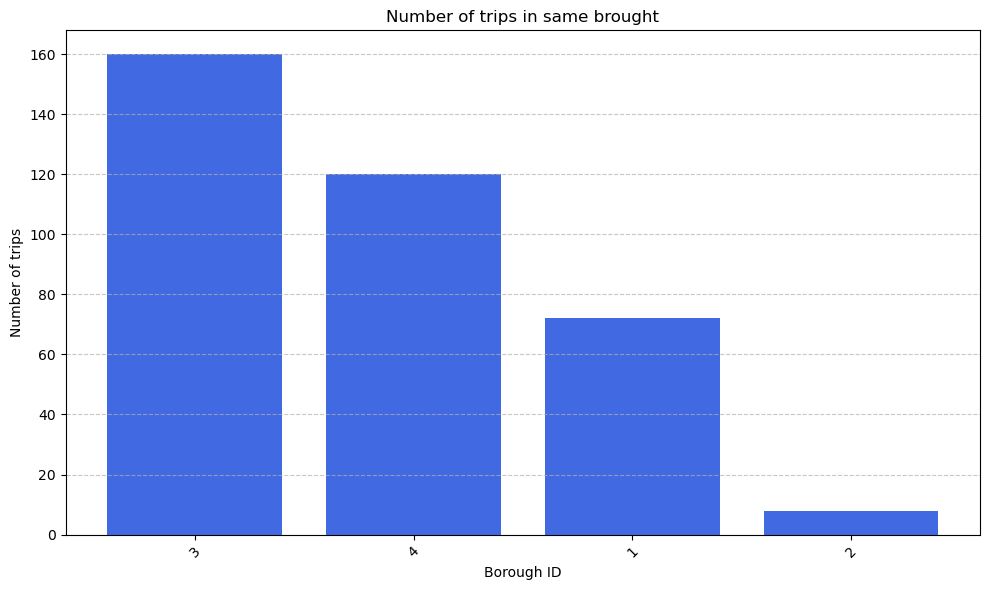

In [22]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np


def read_delta_table(path):
    return spark.read.format("delta").load(path).toPandas()

pd_fares = read_delta_table(f"{output_path}/{table}")

pd_fares['window_start'] = pd_fares['window'].apply(lambda x: pd.to_datetime(x[0]))
pd_fares['window_end'] = pd_fares['window'].apply(lambda x: pd.to_datetime(x[1]))
pd_fares.dropna(subset=['number_of_trips'], inplace=True)

# Calculate the overall average time to the next fare per borough
brought_same_number = pd_fares.groupby('drop_off_location').agg({'number_of_trips': 'sum'}).reset_index()
brought_same_number.sort_values(by='number_of_trips', ascending=False, inplace=True)

plt.figure(figsize=(10, 6))
plt.bar(brought_same_number['drop_off_location'].astype(str), brought_same_number['number_of_trips'], color='royalblue')

plt.xlabel('Borough ID')
plt.ylabel('Number of trips')
plt.title('Number of trips in same brought')
plt.xticks(rotation=45)  # Rotate the labels for better readability
plt.grid(axis='y', linestyle='--', alpha=0.7)  # Add horizontal grid lines for better alignment

plt.tight_layout()
plt.show()

## [Query 4] The number of trips that started in one borough and ended in another one in the last hour

In [15]:
brokers = os.getenv('KAFKA_ADVERTISED_LISTENERS')
protocol = os.getenv('KAFKA_LISTENER_SECURITY_PROTOCOL_MAP') 

lines_4 = (spark.readStream
    .format("kafka")
    .option("kafka.bootstrap.servers", brokers)
    .option("kafka.security.protocol", protocol)
    .option("subscribe", "stock")
    .option("startingOffsets", "earliest")
    .option("maxOffsetsPerTrigger", 100)
    .load()
)
df_4 = lines_4.select(F.from_json(lines_4.value.cast("string"), schema).alias("data")).select("data.*")
df_4.writeStream.format("console").start().awaitTermination(5)

False

In [16]:
checkpoint_path = "./checkpoint" 
output_path = "./output"
table = "different_borough"

df_stream = df_4.withWatermark("drop_off_time", "1 hour")
same_borough_trips = df_stream.filter(
    F.col("pick_up_location") != F.col("drop_off_location")
)
window_duration = "1 hour"
slide_duration = "15 minutes"

# Group by the sliding window and borough, then count the entries
trips_per_borough_per_hour = same_borough_trips.groupBy(
    F.window(F.col("drop_off_time"), window_duration, slide_duration),
    F.col("drop_off_location")
).count().withColumnRenamed("count", "number_of_trips")


query = trips_per_borough_per_hour.writeStream \
    .outputMode("append") \
    .format("delta") \
    .trigger(processingTime="120 seconds") \
    .option("checkpointLocation", f"{checkpoint_path}/{table}") \
    .option("path", f"{output_path}/{table}") \
    .option("mergeSchema", "true") \
    .start()

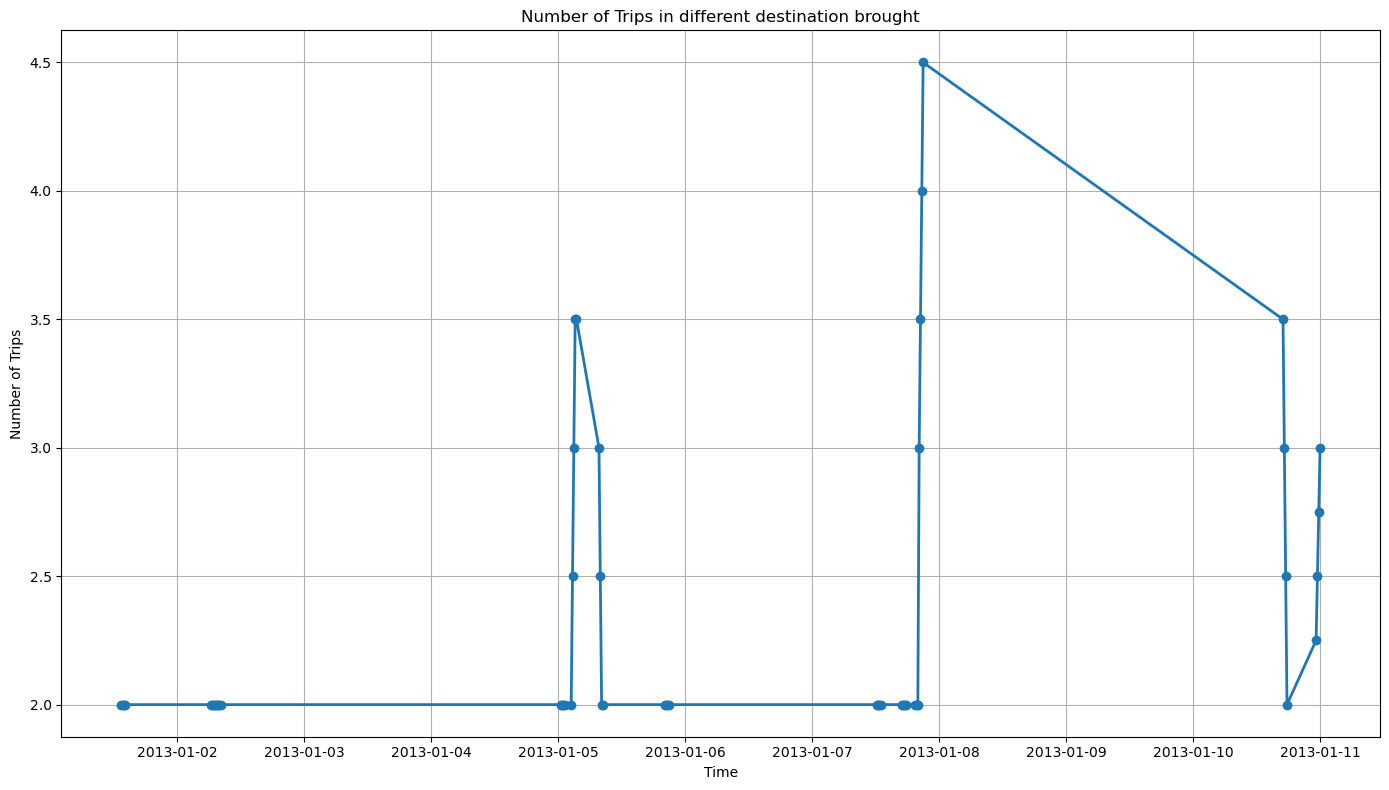

In [21]:
import pandas as pd
import matplotlib.pyplot as plt
from delta.tables import *

# Load the data from the Delta table
def read_delta_table(path):
    return spark.read.format("delta").load(path).toPandas()

# Extract the window start time and convert it to a datetime format
pd_fares['window_start'] = pd_fares['window'].apply(lambda x: x['start'])
pd_fares['window_start'] = pd.to_datetime(pd_fares['window_start'])

# Group by window start time and sum the number of trips
total_trips_per_time = pd_fares.groupby('window_start')['number_of_trips'].sum().reset_index()

# Apply a rolling average to smooth the line
rolling_window_size = 4  # Adjust the window size as needed
total_trips_per_time['smoothed_trips'] = total_trips_per_time['number_of_trips'].rolling(window=rolling_window_size, min_periods=1).mean()

# Plot the number of trips per hour as a smoothed line chart
plt.figure(figsize=(14, 8))
plt.plot(total_trips_per_time['window_start'], total_trips_per_time['smoothed_trips'], marker='o', linestyle='-', linewidth=2)

plt.xlabel('Time')
plt.ylabel('Number of Trips')
plt.title('Number of Trips in different destination brought')
plt.grid(True)
plt.tight_layout()

plt.show()
